# Synthetic data simulation

This notebook generates a dataset of a synthetic cell acquired in 3 channels and exported in h5 format. The movie has 40 frames. The top edge of the cell moves out in frames 0-20 and backwards in frames 20-40. The first channel represents a segmentation channel. The two others contain a gradient of intensity with max at the top edge. That signal increases and decreases over ~20 frames but has a shift of 4 frames between channel #2 and #3.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from morphodynamics.splineutils import splevper, spline_to_param_image, fit_spline
import skimage.filters
import skimage.util
import ipywidgets as ipw
import h5py
from pathlib import Path
#%matplotlib widget

np.random.seed(42)

The simulated data are generated by starting with a circular cell and to progressively deform it. Random displacement is applied on all points. Additionally a constant positive/negative force is applied on the top region of the cell, making it expand and retract.

In [6]:
width = 100
height = 100
radius = 10
position = np.array([50,50])
circle = position+ np.array([[radius*np.cos(x), radius*np.sin(x)] for x in np.arange(0,2*np.pi, 0.01)])
circle_or = circle.copy()
dist_from_point = np.array([np.linalg.norm(x-circle[0,:]) for x in circle])
dist_from_point[dist_from_point < 10] = 0

steps = 40
image_stack = np.zeros((steps, height, width))

grad_image = (np.ones((height, width))*np.arange(0,width)).T
grad_image = grad_image/width
vert_stack = grad_image*np.ones((steps, height, width))
vert_stack = np.rollaxis(vert_stack,0,3)

wave1 = np.sin(-0.3+0.15*np.arange(0,steps))
wave1[wave1<0]=0
wave2 = np.sin(-0.9+0.15*np.arange(0,steps))
wave2[wave2<0]=0

vert_stack1 = vert_stack * wave1
vert_stack2 = vert_stack * wave2

vert_stack1 = np.rollaxis(vert_stack1,2,0)
vert_stack2 = np.rollaxis(vert_stack2,2,0)


for i in range(steps):
    
    if i<20:
        fact = -0.5
    else:
        fact = 0.5
    move_noise = np.random.normal(loc=0,scale=0.5, size=circle.shape)
    move_noise[:,0] += fact*dist_from_point
    circle = circle + 0.1*move_noise
    circle_s, _ = fit_spline(circle, 100)
    
    rasterized = spline_to_param_image(1000, (100,100), circle_s, deltat=0)
    image = binary_fill_holes(rasterized > -1).astype(np.uint8)
    image_stack[i,:,:] = image
    
    temp = vert_stack1[i,:,:]
    temp[image==0] =0
    temp = vert_stack2[i,:,:]
    temp[image==0] =0
    #vert_stack1[image==0] =0

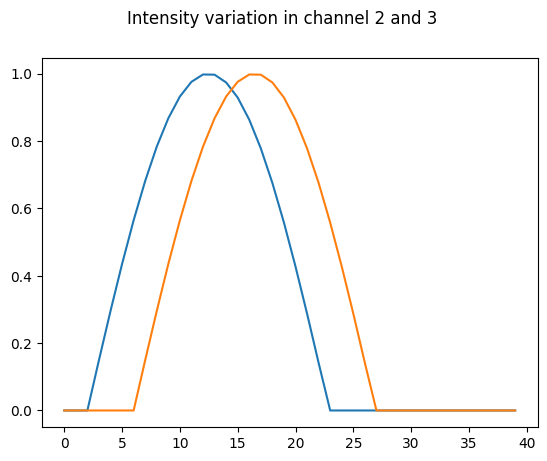

In [8]:
fig, ax = plt.subplots()
plt.plot(wave1)
plt.plot(wave2)
fig.suptitle('Intensity variation in channel 2 and 3');

In [9]:
# make stacks microscopy-like by blurring and adding noise.
im_stack_gauss = skimage.filters.gaussian(image_stack, preserve_range=True)
im_stack_noise = skimage.util.random_noise(im_stack_gauss,'gaussian')
im_stack_noise = skimage.util.img_as_ubyte(im_stack_noise)

signal1_gauss = skimage.filters.gaussian(vert_stack1, preserve_range=True)
signal1_noise = skimage.util.random_noise(signal1_gauss,'gaussian')
signal1_noise = skimage.util.img_as_ubyte(signal1_noise)

signal2_gauss = skimage.filters.gaussian(vert_stack2, preserve_range=True)
signal2_noise = skimage.util.random_noise(signal2_gauss,'gaussian')
signal2_noise = skimage.util.img_as_ubyte(signal2_noise)

In [100]:
def update_fig(ind):
    #im.set_array(im_stack_noise[ind,:,:])
    im.set_array(signal1_noise[ind,:,:])
fig, ax = plt.subplots()
#im = ax.imshow(im_stack_noise[0,:,:], cmap = 'gray')
im = ax.imshow(signal1_noise[0,:,:], cmap = 'gray')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [101]:
ipw.HBox([ipw.interactive(update_fig, ind=ipw.IntSlider(0,0,39))])

## Export as H5

In [102]:
# export data as h5 files
main_folder = Path('./data')

h5_name = main_folder.joinpath('synth_ch1.h5')
with h5py.File(h5_name, "w") as f_out:
    dset = f_out.create_dataset("volume", data=im_stack_noise, chunks=True, compression="gzip", compression_opts=1)

main_folder = Path('./data')

h5_name = main_folder.joinpath('synth_ch2.h5')
with h5py.File(h5_name, "w") as f_out:
    dset = f_out.create_dataset("volume", data=signal1_noise, chunks=True, compression="gzip", compression_opts=1)

main_folder = Path('./data')

h5_name = main_folder.joinpath('synth_ch3.h5')
with h5py.File(h5_name, "w") as f_out:
    dset = f_out.create_dataset("volume", data=signal2_noise, chunks=True, compression="gzip", compression_opts=1)


## Export as zarr

In [10]:
import zarr

In [11]:
im_stack_noise.shape

(40, 100, 100)

In [13]:
full_stack = np.array([im_stack_noise, signal1_noise, signal2_noise])

In [16]:
full_stack.shape

(3, 40, 100, 100)

In [18]:
z1 = zarr.open('synthetic.zarr', mode='w', shape=full_stack.shape, chunks=(3,1,height, width))

In [19]:
z1[:] = full_stack

In [20]:
import napari

In [21]:
viewer = napari.Viewer()
viewer.open('synthetic.zarr/')

[<Image layer 'Image' at 0x28f4ada90>]